# Aprendizaje Supervisado

- Crea un modelo con el máximo valor F1 posible. 
- Para aprobar la revisión, necesitas un valor F1 de al menos 0.59. Verifica F1 para el conjunto de prueba. 
- Además, debes medir la métrica AUC-ROC y compararla con el valor F1.

In [1]:
# Librerias

# Manejo de datos:
import pandas as pd
import numpy as np

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, roc_curve, roc_auc_score

# Visualizacion
from matplotlib import pyplot as plt
import seaborn as sns
tips = sns.load_dataset('tips') 
sns.set_style('darkgrid')

# Lectura de los datos
df = pd.read_csv('/home/andres/anaconda_projects/TripleTen/Sprint 11/Churn.csv')

In [2]:
# Info de los datos
df.info()
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Comentario:**
*1. Las primeras 3 columnas del DataFrame son identificadores unicos los cuales pueden llevar al modelo al sobreajuste porque va a memorizar informacion de salida unica para cada cliente. Enfocarse en las columnas que generalizan constan de (Valores escalares como: 'Balance', 'Credit Score') o (valores categoricos como: 'Gender' o Geography)(Las cuales generalizacion la informacion).
2. El uso de estas columnas ['RowNumber','CustomerId','Surname'] con identificadores unicos consumiran muchos recurso, especialmente la de apellidos, ya que utilizare one-hot-encoding para manejar categorias ademas provocara sobreajuste. Por tanto se deben aliminar:*

## Limpieza de Datos y Preprocesamiento de Datos

In [3]:
# Elimino las columnas que no usare para los modelos:
df = df.drop(labels=['RowNumber','CustomerId','Surname'], axis=1)
display(df.head(3))

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1


In [4]:
# Valores ausentes:
print(f"Numero de valores ausentes: {df['Tenure'].isnull().sum()}")
print()
# Valores Unicos para la columna Ternure
print(f"Valores unicos para la columna 'Tenure': {sorted(df['Tenure'].unique().tolist())}")
print()
# Podemos rellenar con la media los valores ausentes:
media_tenure = df['Tenure'].mean().round()
df['Tenure'] = df['Tenure'].fillna(media_tenure)

print(f"Nuevos valores unicos: {sorted(df['Tenure'].unique().tolist())}")
print()
print(f"Total de valores ausentes despues del relleno: {df['Tenure'].isnull().sum()}")
print()

Numero de valores ausentes: 909

Valores unicos para la columna 'Tenure': [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, nan]

Nuevos valores unicos: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]

Total de valores ausentes despues del relleno: 0



In [5]:
# One-hot Encoding para Geography y gender:
print(f"Valores unicos para Geography: {sorted(df['Geography'].unique().tolist())}")
print()
df = pd.get_dummies(df, columns=['Geography','Gender'], drop_first=True)
display(df.head(1))
df.to_csv('data_limpia.csv',index=False)
print()
# France queda fuera del encoding porque esta se determina por mera eliminacion (drop_first=True):
# Si Spain & Germany =  0 entonces France = 1

print('*'*150)
# Balance de clases para la columna objetivo:
clases_percent = df['Exited'].value_counts(normalize=True)
print('Balance de clases (Columna Objetivo)(Exited)')
print(clases_percent)
print('0\'s = 80%, 1\'s = 20%')

Valores unicos para Geography: ['France', 'Germany', 'Spain']



,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.0,1,1,1,101348.88,1,False,False,False



******************************************************************************************************************************************************
Balance de clases (Columna Objetivo)(Exited)
Exited
0    0.7963
1    0.2037
Name: proportion, dtype: float64
0's = 80%, 1's = 20%


**NOTA:**
- *El balance de clases es aceptable, por encima del minimo de un 10% para la clase minoritaria. Para los modelos se especificara el hiperparametro 'class_weight='balanced' para un mejor 'perforrmance'. Tambien se usara una practica de sobremuestreo para mejorar el equilibrio de clases:*

In [6]:
# Segmentacion de datos:
features = df.drop(['Exited'],axis=1)
target = df['Exited']

# Segmentare los datos con el ratio 3:1:1 
# 60% para entrenamiento
# 20% para validacion
# 20% para prueba final

features_train, features_40, target_train, target_40 = train_test_split(features,target,test_size=0.4,random_state = 12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_40,target_40,test_size=0.5,random_state=12345)

print('Entrenamiento',features_train.shape,target_train.shape)
print('Validacion   ',features_valid.shape, target_valid.shape)
print('Prueba final ',features_test.shape, target_test.shape)

# Creo Sobre muestreo para ajustar el problema de desequilibrio de la clase 1
# Mascaras para el conjunto Train (de valores 0's y 1's para features vaiables y target variable)
features_train_0 = features_train[target_train == 0]
features_train_1 = features_train[target_train == 1]
target_train_0 = target_train[target_train == 0]
target_train_1 = target_train[target_train == 1]

# Se calcula la relacion para usarlo mas adelante como el (multiplo)
filas0 = features_train_0.shape[0]
filas1 = features_train_1.shape[0]
repetidor = round(filas0/filas1)

# Se sobremuestrean los datos:
oversampled_features_train = pd.concat([features_train_0] + [features_train_1] * repetidor)
oversampled_target_train = pd.concat([target_train_0] + [target_train_1] * repetidor)

# Se reacomoda su posicion:
features_train_sobremuestreo, target_train_sobremuestreo = shuffle(oversampled_features_train, oversampled_target_train, random_state=12345)
print()
print(f'Data de Entrenamiento con sobremuestreo {features_train_sobremuestreo.shape},{target_train_sobremuestreo.shape}')

Entrenamiento (6000, 11) (6000,)
Validacion    (2000, 11) (2000,)
Prueba final  (2000, 11) (2000,)

Data de Entrenamiento con sobremuestreo (9588, 11),(9588,)


## MODELOS

Score F1 Entrenamiento: 0.49, Score F1 Validacion: 0.50

Score AUC del modelo validacion 0.76


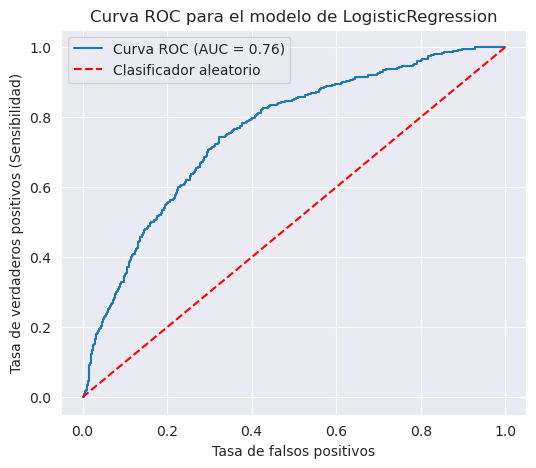

In [7]:
# Modelo: LogisticRegression
model_1 = LogisticRegression(random_state=12345,solver='liblinear',class_weight='balanced')
model_1.fit(features_train,target_train) # NO se utiliza el sobremuestreo, el modelo aprende mejor sin el.

# Se calculan predicciones para el entrenamiento como para validacion, servira para la grafica de curva ROC.
prediccion_train_1 = model_1.predict(features_train)
prediccion_valid_1 = model_1.predict(features_valid)

# Obtenemos la posibilidad de obtener 1 para el conjunto de validacion al predecir:
probabilities_valid_1 = model_1.predict_proba(features_valid)[:,1]

print(f'Score F1 Entrenamiento: {f1_score(target_train, prediccion_train_1):.2f}, Score F1 Validacion: {f1_score(target_valid, prediccion_valid_1):.2f}')
print()

fpr_1, tpr_1, thresholds_1 = roc_curve(target_valid, probabilities_valid_1)
auc_score_1 = roc_auc_score(target_valid, probabilities_valid_1)

print(f'Score AUC del modelo validacion {auc_score_1:.2f}')

# Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_1, tpr_1, label=f'Curva ROC (AUC = {auc_score_1:.2f})')
plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC para el modelo de LogisticRegression')
plt.legend(loc='upper left')
plt.show()

*Este modelo tiene buena sensibilidad para la clase 1 que representa clientes que dejan el banco, el modelo esta equilibrado  dado que el valor f1 del conjunto de entrenamiento es igual que el valor f1 del modelo, sin embargo el valor f1 del conjunto de validacion es de 45% es bastante mas bajo que el deseado de un minimo de 60%. Para este modelo ocupe class_weight='balanced' para lidiar con la clase desequilibrada.*

Score F1 Entrenamiento 0.74, Score F1 Validacion 0.60

Score AUC del modelo validacion 0.84


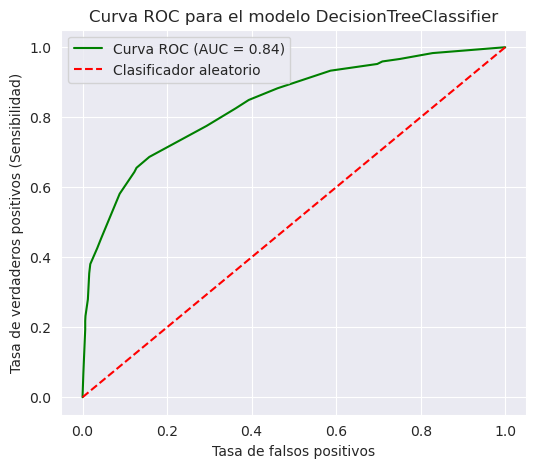

In [8]:
# Modelo: DecisionTreeClassifier
model_2 = DecisionTreeClassifier(random_state=12345,max_depth=5,min_samples_split=10,min_samples_leaf=25,class_weight='balanced')
model_2.fit(features_train_sobremuestreo, target_train_sobremuestreo)

# Se calculan predicciones para el entrenamiento como para validacion, servira para la grafica de curva ROC.
prediccion_train_2 = model_2.predict(features_train_sobremuestreo)
prediccion_valid_2 = model_2.predict(features_valid)

# Obtenemos la posibilidad de obtener 1 para el conjunto de validacion al predecir:
probabilities_valid_2 = model_2.predict_proba(features_valid)[:,1]

print(f'Score F1 Entrenamiento {f1_score(target_train_sobremuestreo, prediccion_train_2):.2f}, Score F1 Validacion {f1_score(target_valid, prediccion_valid_2):.2f}')
print()

fpr_2, tpr_2, thresholds_2 = roc_curve(target_valid, probabilities_valid_2)
auc_score_2 = roc_auc_score(target_valid, probabilities_valid_2)

print(f'Score AUC del modelo validacion {auc_score_2:.2f}')

# Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_2, tpr_2, label=f'Curva ROC (AUC = {auc_score_2:.2f})',color='green')
plt.plot([0, 1], [0, 1], 'r--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC para el modelo DecisionTreeClassifier')
plt.legend(loc='upper left')
plt.show()

*Para DecisionTreeClassifier se obtiene un puntaje 60% como exige el ejercicio para los datos de validacion pero el puntaje f1 del conjunto de entrenamiento fue de 73% despues de haber ajustado varios hiper parametros. Esto indica un sobreajuste de 13 unidades. Para el puntaje AUC el modelo alcanzo un 82% lo que indica buena distincion de clases y asi mismo se puede ver en la grafica de la curva ROC. Sin embargo la mejora con respecto a la Regresion Logistica es notable.*

Score F1 Entrenamiento 0.77,Score F1 Validacion: 0.60

Score AUC del modelo validacion 0.85


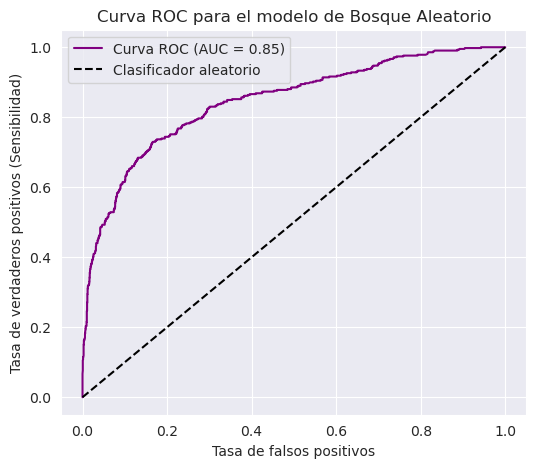

In [9]:
# Modelo: RandomForestClassifier
model_3 = RandomForestClassifier(random_state=12345,n_estimators=100,max_depth=25,max_leaf_nodes=10,min_samples_leaf=25)
model_3.fit(features_train_sobremuestreo, target_train_sobremuestreo)

# Se calculan predicciones para el entrenamiento como para validacion, servira para la grafica de curva ROC.
prediccion_train_3 = model_3.predict(features_train_sobremuestreo)
prediccion_valid_3 = model_3.predict(features_valid)

# Obtenemos la posibilidad de obtener 1 para el conjunto de validacion al predecir:
probabilities_valid_3 = model_3.predict_proba(features_valid)[:,1]

print(f'Score F1 Entrenamiento {f1_score(target_train_sobremuestreo, prediccion_train_3):.2f},Score F1 Validacion: {f1_score(target_valid, prediccion_valid_3):.2f}')
print()

fpr_3, tpr_3, thresholds_3 = roc_curve(target_valid, probabilities_valid_3)
auc_score_3 = roc_auc_score(target_valid, probabilities_valid_3)

print(f'Score AUC del modelo validacion {auc_score_3:.2f}')

# Curva ROC
plt.figure(figsize=(6,5))
plt.plot(fpr_3, tpr_3, label=f'Curva ROC (AUC = {auc_score_3:.2f})',color='purple')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC para el modelo de Bosque Aleatorio')
plt.legend(loc='upper left')
plt.show()

*Este modelo tiene una curva mas suavizada, su sobreajuste alcanza las 15 unidades de diferencia sin embargo tiene una sencibilidad optima para la deteccion de la clase "1". Se alcanzo el umbral del 60% para datos de validacion el matrica Score F1.*

## Mejor Modelo - Prueba Final

Puntaje F1 RandomForestClassifier Test Data: 0.59

Score AUC del modelo 4 (Conjunto de Prueba) 0.84


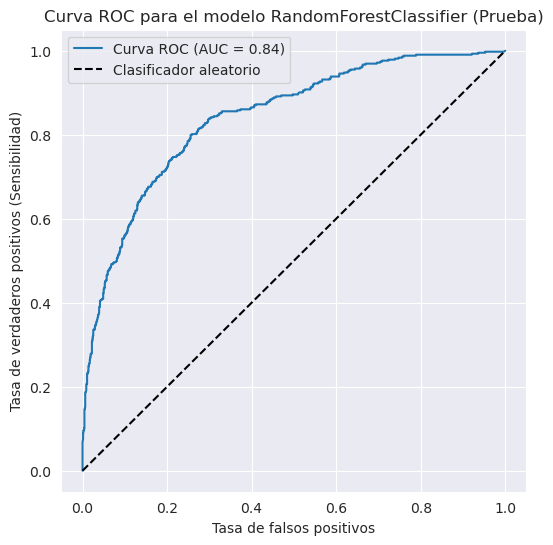

In [10]:
# Mejor Modelo RandomForestClassifier

# Se calculan predicciones para el entrenamiento como para validacion, servira para la grafica de curva ROC.
prediccion_test = model_3.predict(features_test)
probabilities_test = model_3.predict_proba(features_test)[:,1]

print(f'Puntaje F1 RandomForestClassifier Test Data: {f1_score(target_test,prediccion_test):.2f}')
print()

fpr_test, tpr_test, thresholds_test = roc_curve(target_test, probabilities_test)
auc_score_test = roc_auc_score(target_test, probabilities_test)

print(f'Score AUC del modelo 4 (Conjunto de Prueba) {auc_score_test:.2f}')

# Curva ROC
plt.figure(figsize=(6,6))
plt.plot(fpr_test, tpr_test, label=f'Curva ROC (AUC = {auc_score_test:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Clasificador aleatorio')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos (Sensibilidad)')
plt.title('Curva ROC para el modelo RandomForestClassifier (Prueba)')
plt.legend(loc='upper left')
plt.show()

- La prueba final fue postivia, se alcanzo el 59% deseado como minimo para el conjunto de prueba. La sensibilidad para verdaderos positivos se mantuvo estable.
- En total utlize (**sobremuestreo**) y (**class_weight**) para trabajar con el desequilibrio de clases.